In [28]:
# Importing Required Libraries
import os
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

In [29]:
# Path to input dataset directory
dataset_path = '/kaggle/input/new-wc-dataset/Dataset_Weed_Crop'

# Defining constants
image_size = (32, 32)  # LeNet-5 expects input size (32, 32)
num_classes = 2  # Crop and Weed

# Creating empty lists to store data
data = []
labels = []

# Loading and preprocessing the dataset
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    class_label = 0 if class_name == 'Crop' else 1  # Assign labels (0 for Crop, 1 for Weed)
    for image_filename in os.listdir(class_path):
        image_path = os.path.join(class_path, image_filename)
        image = load_img(image_path, target_size=image_size)
        image = img_to_array(image)
        image = image / 255.0  # Rescale pixel values to [0, 1]
        data.append(image)
        labels.append(class_label)

# Converting data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

In [30]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# To Print the shapes to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (4200, 32, 32, 3), y_train shape: (4200, 2)
X_val shape: (900, 32, 32, 3), y_val shape: (900, 2)
X_test shape: (900, 32, 32, 3), y_test shape: (900, 2)


In [31]:
# Data Augmentation
# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,  # You can adjust the rotation range as needed
    width_shift_range=0.2,  # You can adjust the shift range as needed
    height_shift_range=0.2,
    fill_mode='nearest'  # Filling mode for pixels outside the boundaries
)

# Fit the generator on the training data
train_datagen.fit(X_train)

# Create data generators for training and validation
batch_size = 32  # You can adjust the batch size as needed
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = ImageDataGenerator(rescale=1./255).flow(X_val, y_val, batch_size=batch_size)

In [33]:
# Define class weights to handle imbalance
class_labels = np.unique(labels)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=labels)
class_weight_dict = dict(zip(class_labels, class_weights))

# LeNet-5 Model
def create_lenet5_model(input_shape=(32, 32, 3), num_classes=2):
    model = Sequential()

    model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape, padding='same'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', padding='valid'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(120, kernel_size=(5, 5), activation='relu', padding='valid'))

    model.add(Flatten())
    model.add(Dense(84, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Saving the LeNet-5 model in model
model = create_lenet5_model(input_shape=(32, 32, 3), num_classes=2)

# Display the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d_8 (Avera  (None, 16, 16, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_9 (Avera  (None, 6, 6, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_14 (Conv2D)          (None, 2, 2, 120)         48120     
                                                                 
 flatten_4 (Flatten)         (None, 480)              

In [34]:
# Train the model with class weights and early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,  # You can adjust the maximum number of epochs
    validation_data=val_generator,
    validation_steps=len(val_generator),
    class_weight=class_weight_dict,  # Using class weights
    use_multiprocessing=False,
    callbacks=[early_stopping]  # EarlyStopping callback
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

Epoch 1/50
132/132 [==============================] - 5s 25ms/step - loss: 0.5503 - accuracy: 0.6774 - val_loss: 0.3303 - val_accuracy: 0.8644
Epoch 2/50
132/132 [==============================] - 3s 25ms/step - loss: 0.2149 - accuracy: 0.9145 - val_loss: 0.2435 - val_accuracy: 0.8900
Epoch 3/50
132/132 [==============================] - 3s 24ms/step - loss: 0.1477 - accuracy: 0.9500 - val_loss: 0.1533 - val_accuracy: 0.9467
Epoch 4/50
132/132 [==============================] - 3s 24ms/step - loss: 0.1151 - accuracy: 0.9586 - val_loss: 0.1251 - val_accuracy: 0.9500
Epoch 5/50
132/132 [==============================] - 3s 24ms/step - loss: 0.0879 - accuracy: 0.9679 - val_loss: 0.1486 - val_accuracy: 0.9367
Epoch 6/50
132/132 [==============================] - 3s 24ms/step - loss: 0.0678 - accuracy: 0.9764 - val_loss: 0.0858 - val_accuracy: 0.9656
Epoch 7/50
132/132 [==============================] - 3s 24ms/step - loss: 0.0706 - accuracy: 0.9733 - val_loss: 0.1044 - val_accuracy: 0.9578

In [35]:
# Create a data generator for the test set
test_generator = ImageDataGenerator(rescale=1./255).flow(X_test, y_test, batch_size=1, shuffle=False)

# Get predictions from the model
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the classification report
report = classification_report(y_true, y_pred_classes, target_names=['Crop', 'Weed'])
print(report)

900/900 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

        Crop       1.00      0.99      0.99       440
        Weed       0.99      1.00      0.99       460

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



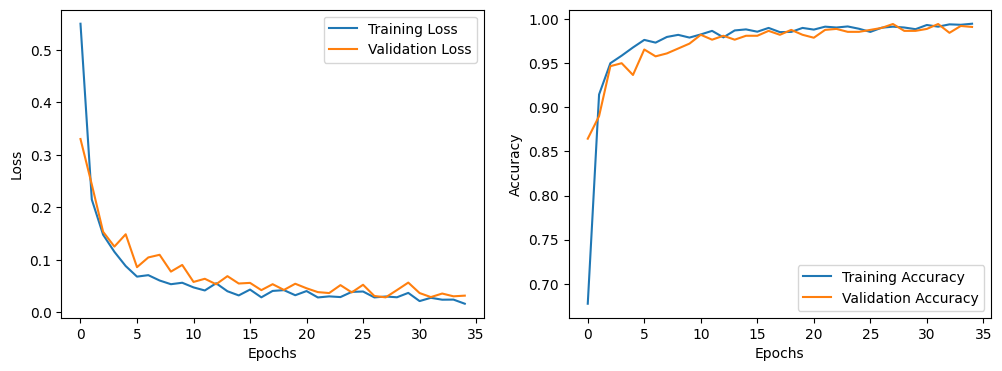

In [36]:
#Visualize Training and Validation Curves
# Extract training history from the history object
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

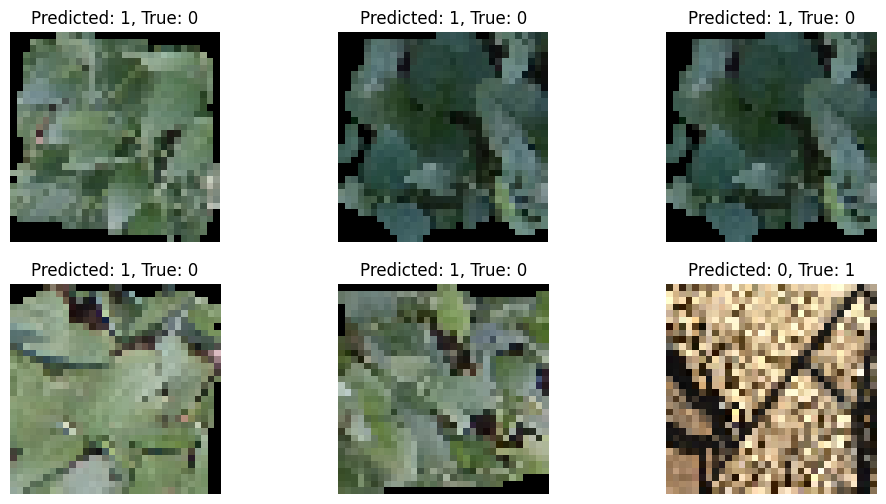

In [37]:
#Analyze Misclassified Images
import random

misclassified_images = []

for i in range(len(y_true)):
    if y_pred_classes[i] != y_true[i]:
        misclassified_images.append((X_test[i], y_pred_classes[i], y_true[i]))

# Randomly select and display some misclassified images
plt.figure(figsize=(12, 6))
num_displayed = min(6, len(misclassified_images))
for i in range(num_displayed):
    index = random.randint(0, len(misclassified_images) - 1)
    image, predicted_class, true_class = misclassified_images[index]
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}, True: {true_class}')
    plt.axis('off')

plt.show()


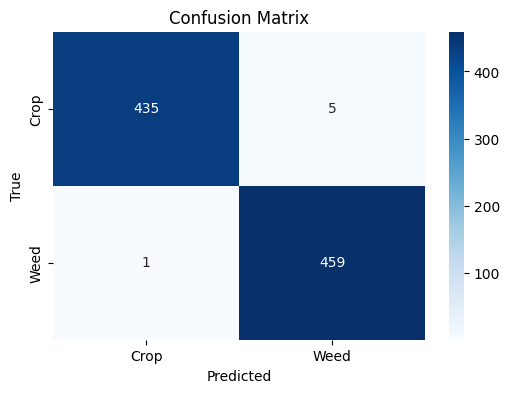

In [38]:
# Compute the confusion matrix
confusion = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
labels = ['Crop', 'Weed']
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()